In [1]:
import pandas as pd
import numpy as np
import regex
from underthesea import sent_tokenize, word_tokenize, pos_tag
import string
from mds5.analyzer.processor.text import TextProcessor
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
STOP_WORD_FILE = 'vietnamese-stopwords.txt'

In [4]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

### Read and overview dataset

In [5]:
# Load the CSV file
df = pd.read_csv("Products_ThoiTrangNam_raw.csv")
df.head()

,product_id,product_name,category,sub_category,link,image,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


In [6]:
# Basic inspection
print("Initial shape:", df.shape)
print("Columns:", df.columns)

# Drop rows with all NaNs
df.dropna(subset = "description", inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Drop irrelevant or unnamed columns
#df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Fill or remove missing values (adjust based on data)
#df = df.dropna(subset=['name'])  # Ensure 'name' column is not null

# Combine text columns for NLP (adjust columns as needed)
df['text'] = df['product_name'].astype(str) + " " + df.get('description', "").astype(str)

# View processed sample
df[['text']].head()


Initial shape: (49663, 9)
Columns: Index(['product_id', 'product_name', 'category', 'sub_category', 'link',
       'image', 'price', 'rating', 'description'],
      dtype='object')


,text
0,"Áo ba lỗ thun gân ,form body tôn dáng Danh Mục..."
1,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu ..."
2,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không..."
3,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON Danh Mục\nS...
4,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...


In [7]:
# Normalize Vietnamese text for NLP

import re
from underthesea import word_tokenize

# Function to normalize text
def normalize_text(text):
    text = text.lower()                                # lowercase
    text = re.sub(r"[\n\r]", " ", text)              # remove line breaks
    text = re.sub(r"http\S+|www\.\S+", "", text)    # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\sáàảãạâấầẩẫậăắằẳẵặéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()          # remove extra spaces
    return text

# Apply normalization
df['clean_text'] = df['text'].apply(normalize_text)

# Tokenize for Vietnamese
df['tokens'] = df['clean_text'].apply(lambda x: word_tokenize(x, format="text"))

# Show sample
df[['clean_text', 'tokens']].head()

,clean_text,tokens
0,áo ba lỗ thun gân form body tôn dáng danh mục ...,áo ba lỗ thun gân form body tôn_dáng danh_mục ...
1,áo ba lỗ nam trắng chất cotton siêu mát siêu đ...,áo ba lỗ nam trắng chất_cotton siêu_mát siêu_đ...
2,áo ba lỗ nam tyasuo chất vải co dãn mát không ...,áo ba lỗ nam tyasuo chất vải co_dãn mát không ...
3,áo ba lỗ hàng việt nam 100 cotton danh mục sho...,áo ba lỗ hàng việt_nam 100 cotton danh_mục sho...
4,áo thun nam thể thao ba lỗ mẫu mới siêu đẹp bl...,áo thun nam thể_thao ba lỗ mẫu mới siêu_đẹp bl...


In [8]:
STOP_WORD_FILE = 'vietnamese-stopwords.txt'

with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

vietnamese_stopwords = stop_words.split('\n')

In [9]:
# Remove Vietnamese stopwords and apply TF-IDF

# Sample Vietnamese stopwords list (can be replaced with a better list)

# Remove stopwords
def remove_stopwords(text):
    tokens = text.split()
    filtered = [word for word in tokens if word not in vietnamese_stopwords]
    return " ".join(filtered)

df['filtered_text'] = df['tokens'].apply(remove_stopwords)

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['filtered_text'])

# Show shape of TF-IDF matrix
print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (48700, 140530)


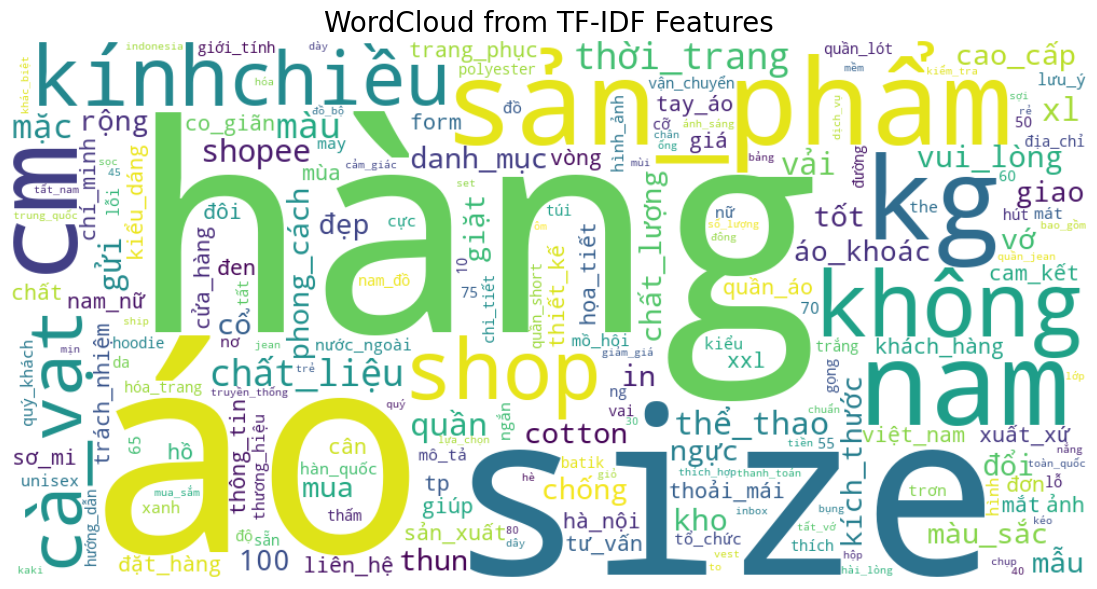

In [10]:
# Visualize TF-IDF features using WordCloud (optimized for memory)

# Get TF-IDF vocabulary and scores
feature_names = tfidf.get_feature_names_out()
tfidf_scores_sparse = X_tfidf.sum(axis=0)  # sum directly on sparse matrix
tfidf_scores = np.asarray(tfidf_scores_sparse).flatten()  # convert to 1D array

# Create dictionary of word: score
tfidf_dict = dict(zip(feature_names, tfidf_scores))

# Generate WordCloud
wordcloud_tfidf = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(tfidf_dict)

# Display
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud_tfidf, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud from TF-IDF Features", fontsize=20)
plt.show()

In [11]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

## Cosine_similarity + Word2Vec

In [12]:
# Chuẩn bị dữ liệu: tách từ từ filtered_text
token_lists = df['filtered_text'].apply(lambda x: x.split()).tolist()

In [13]:
# Huấn luyện mô hình Word2Vec
w2v_model = Word2Vec(sentences=token_lists, vector_size=100, window=5, min_count=2, workers=4)

In [14]:
# Tạo vector trung bình cho từng sản phẩm từ từ trong filtered_text
def get_product_vector(text, model):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if word_vecs:
        return np.mean(word_vecs, axis=0)
    else:
        return np.zeros(model.vector_size)

# Hàm đề xuất theo product_id
def recommend_by_product_id(input_id, topn=5):
    if input_id not in product_ids:
        print("product_id không tồn tại!")
        return

    idx = np.where(product_ids == input_id)[0][0]
    sim_scores = cosine_similarity([product_matrix[idx]], product_matrix)[0]
    top_indices = sim_scores.argsort()[::-1][1:topn+1]

    print(f"Top {topn} sản phẩm tương tự với product_id = {input_id}:")
    return df.iloc[top_indices]

In [15]:
# Tạo ma trận vector đại diện cho toàn bộ sản phẩm
product_vectors = df['filtered_text'].apply(lambda x: get_product_vector(x, w2v_model))
product_matrix = np.vstack(product_vectors.values)

# Tạo bảng ánh xạ product_id (nếu có)
product_ids = df['product_id'].values  # đảm bảo cột này tồn tại

In [16]:
a = 199
display(df[df['product_id']==a])
# Ví dụ sử dụng:
recommend_by_product_id(a)  # thay bằng product_id thực tế trong dataset

,product_id,product_name,category,sub_category,link,image,price,rating,description,text,clean_text,tokens,filtered_text
9,199,Áo Lót Nam Đông Xuân Xuất Nhật Maxtino Màu Trắ...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-L%C3%B3t-Nam-%C4%90%...,NaN,49550.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,Áo Lót Nam Đông Xuân Xuất Nhật Maxtino Màu Trắ...,áo lót nam đông xuân xuất nhật maxtino màu trắ...,áo lót nam đông xuân xuất_nhật maxtino màu trắ...,áo lót nam đông xuân xuất_nhật maxtino màu trắ...


Top 5 sản phẩm tương tự với product_id = 199:


,product_id,product_name,category,sub_category,link,image,price,rating,description,text,clean_text,tokens,filtered_text
913,19413,{Mua 4 áo TẶNG 1 áo} Áo Lót Nam Đông Xuân Xuất...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/-Mua-4-%C3%A1o-T%E1%BA%B6NG-...,NaN,81000.0,5.0,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nKh...,{Mua 4 áo TẶNG 1 áo} Áo Lót Nam Đông Xuân Xuất...,mua 4 áo tặng 1 áo áo lót nam đông xuân xuất n...,mua 4 áo tặng 1 áo áo_lót nam đông xuân xuất_n...,mua 4 áo tặng 1 áo áo_lót nam đông xuân xuất_n...
1376,19876,SỈ ÁO ĐÔNG XUÂN NAM HÀNG COTTON CAO CẤP(CÓ ẢNH...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/S%E1%BB%88-%C3%81O-%C4%90%C3...,NaN,35000.0,5.0,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nPh...,SỈ ÁO ĐÔNG XUÂN NAM HÀNG COTTON CAO CẤP(CÓ ẢNH...,sỉ áo đông xuân nam hàng cotton cao cấp có ảnh...,sỉ áo đông xuân nam hàng cotton cao_cấp có ảnh...,sỉ áo đông xuân nam hàng cotton cao_cấp ảnh da...
6714,18330,Áo lót nam trắng cotton hanoisimex thấm hút mồ...,Thời Trang Nam,Áo,https://shopee.vn/%C3%81o-l%C3%B3t-nam-tr%E1%B...,https://cf.shopee.vn/file/957e7118babbd8cd7b75...,40000.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo\nÁo Thun\...,Áo lót nam trắng cotton hanoisimex thấm hút mồ...,áo lót nam trắng cotton hanoisimex thấm hút mồ...,áo lót nam trắng cotton hanoisimex thấm hút mồ...,áo lót nam trắng cotton hanoisimex thấm hút mồ...
22708,25369,Aó thun Lót Nam HANOIVIETNAM áo không tay 3 l...,Thời Trang Nam,Đồ Lót,https://shopee.vn/A%C3%B3-thun-L%C3%B3t-Nam-HA...,NaN,32500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nĐồ Lót\nÁo L...,Aó thun Lót Nam HANOIVIETNAM áo không tay 3 l...,aó thun lót nam hanoivietnam a o không tay 3 l...,áo thun lót nam hanoivietnam a_o không tay 3 l...,áo thun lót nam hanoivietnam a_o không 3 lỗ cộ...
23483,251144,ÁO GIỮ NHIỆT NAM- CỔ 3 PHÂN - MẶT TRONG LÓT NỈ...,Thời Trang Nam,Đồ Lót,https://shopee.vn/%C3%81O-GI%E1%BB%AE-NHI%E1%B...,NaN,66000.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nĐồ Lót\nĐồ L...,ÁO GIỮ NHIỆT NAM- CỔ 3 PHÂN - MẶT TRONG LÓT NỈ...,áo giữ nhiệt nam cổ 3 phân mặt trong lót nỉ ca...,áo giữ nhiệt nam cổ 3 phân_mặt trong lót_nỉ ca...,áo nhiệt nam cổ 3 phân_mặt lót_nỉ cao_cấp thời...


In [17]:
cosine_sim = cosine_similarity(product_matrix)

In [18]:
import numpy as np
import os

os.makedirs("cosine_batches", exist_ok=True)

batch_size = 1000
n = cosine_sim.shape[0]

for i in range(0, n, batch_size):
    batch = cosine_sim[i:i + batch_size]
    np.save(f"cosine_batches/cosine_batch_{i // batch_size}.npy", batch)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_cosine_similarity_in_batches(matrix, batch_size=1000):
    n_samples = matrix.shape[0]
    sim_matrix = np.zeros((n_samples, n_samples), dtype=np.float32)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_sim = cosine_similarity(matrix[start:end], matrix)
        sim_matrix[start:end] = batch_sim
        print(f"Processed batch {start} to {end}")

    return sim_matrix

In [20]:
cosine_sim = compute_cosine_similarity_in_batches(product_matrix, batch_size=500)

Processed batch 0 to 500
Processed batch 500 to 1000
Processed batch 1000 to 1500
Processed batch 1500 to 2000
Processed batch 2000 to 2500
Processed batch 2500 to 3000
Processed batch 3000 to 3500
Processed batch 3500 to 4000
Processed batch 4000 to 4500
Processed batch 4500 to 5000
Processed batch 5000 to 5500
Processed batch 5500 to 6000
Processed batch 6000 to 6500
Processed batch 6500 to 7000
Processed batch 7000 to 7500
Processed batch 7500 to 8000
Processed batch 8000 to 8500
Processed batch 8500 to 9000
Processed batch 9000 to 9500
Processed batch 9500 to 10000
Processed batch 10000 to 10500
Processed batch 10500 to 11000
Processed batch 11000 to 11500
Processed batch 11500 to 12000
Processed batch 12000 to 12500
Processed batch 12500 to 13000
Processed batch 13000 to 13500
Processed batch 13500 to 14000
Processed batch 14000 to 14500
Processed batch 14500 to 15000
Processed batch 15000 to 15500
Processed batch 15500 to 16000
Processed batch 16000 to 16500
Processed batch 16500


KeyboardInterrupt

